# Effect of Class Time on Grades, For Math Classes

Alexander Bailey, Kayli Leung

## Question

Is a significant difference in the percentage of A's given based on whether a class starts before noon or after noon, given that the class is a math class. 

## Hypotheses

H<sub>0</sub>: There is no significant difference in the mean percentage of A's in the morning classes and afternoon math classes.

$\mu$<sub>AM</sub> = $\mu$<sub>PM</sub>

H<sub>A</sub>: There is a significant difference in the mean percentage of A's in the morning and afternoon math classes.

$\mu$<sub>AM</sub> $\neq$ $\mu$<sub>PM</sub>

## Methodology
We will perform a two-tail, two-sample t-test on the data. This is a refinement of a previous hypothesis, but now we are looking exclusively at Math classes. 

We select an *alpha* value of 0.05.

Class start and end time is listed in minutes from midnight.

## Import Statements

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats
%config InlineBackend.figure_format ='retina'
from simulations import clean_df, get_sample_size

np.random.seed(45)

## Connect to Database and Retrieve Data

In [2]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [3]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
, sub.name
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number
INNER JOIN
  subject_memberships sub_m
ON
  sub_m.course_offering_uuid = sect.course_offering_uuid
INNER JOIN
  subjects sub
ON
  sub.code = sub_m.subject_code
AND 
  sect.course_offering_uuid = grade.course_offering_uuid
WHERE
  sub.name = 'Mathematics';
"""

In [4]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name
0,2,1,1,2,2,2,1,660,LEC,7f8ded97-695f-326e-97f1-a62293258178,1,Mathematics
1,2,1,4,1,3,1,0,800,LEC,7f8ded97-695f-326e-97f1-a62293258178,2,Mathematics
2,2,2,8,2,2,0,1,595,LEC,c9a679c5-8852-3cf7-94b2-917f5e749f58,1,Mathematics
3,3,1,0,4,5,0,2,800,LEC,c9a679c5-8852-3cf7-94b2-917f5e749f58,2,Mathematics
4,4,5,5,2,5,5,2,595,LEC,5144f795-9d64-3e39-949c-30b051952990,1,Mathematics


## Data Cleaning

In [5]:
cleaned_df = clean_df(df)

In [6]:
#cleaned_df.to_pickle("grades_for_time.pkl")
cleaned_df = pd.read_pickle("grades_for_time.pkl")

In [7]:
cleaned_df.loc[cleaned_df['start_time'] != -1, 'section_type'].value_counts()

LEC    2784
SEM      39
Name: section_type, dtype: int64

There are a number of classes that start at -1. As all these values are no use to our test (because we are interested in start time) we will drop all start_times of -1. We will also cut of irregular times (classes that start before 6AM) because these are potentially errors during input. 

In [8]:
cleaned_df = cleaned_df[cleaned_df['start_time'] >= 360]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2823 entries, 0 to 3534
Data columns (total 13 columns):
a_count                 2823 non-null int64
ab_count                2823 non-null int64
b_count                 2823 non-null int64
bc_count                2823 non-null int64
c_count                 2823 non-null int64
d_count                 2823 non-null int64
f_count                 2823 non-null int64
start_time              2823 non-null int64
section_type            2823 non-null object
course_offering_uuid    2823 non-null object
section_number          2823 non-null int64
name                    2823 non-null object
total_count             2823 non-null int64
dtypes: int64(10), object(3)
memory usage: 308.8+ KB


In [9]:
cleaned_df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name,total_count
2517,1,0,0,0,0,0,0,725,LEC,cc08c0c9-2119-330c-8bbc-55a6f28dc755,1,Mathematics,1
2561,6,0,0,0,0,0,0,870,SEM,bc9bb0ae-f78f-32e2-9812-32b6b430eee9,5,Mathematics,6
3373,3,2,1,0,0,0,0,660,LEC,1f795ad6-8b91-3141-9d29-438e7884ccfc,1,Mathematics,6
3251,6,0,0,0,0,0,0,800,SEM,47f852a6-adb4-363b-a855-fb4e098772e6,1,Mathematics,6
1932,2,0,0,1,2,1,0,570,LEC,d776bdea-d59d-3cd1-9481-066eb87b414b,1,Mathematics,6


We create the column with the ratio of As for each class.

In [10]:
ratio_column = np.array(cleaned_df['a_count'] / cleaned_df['total_count'])

In [11]:
cleaned_df['ratio_of_as'] = ratio_column

There are duplicate entries, so we will remove those.

In [12]:
cleaned_df.drop_duplicates(inplace=True)
cleaned_df.shape

(2661, 14)

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


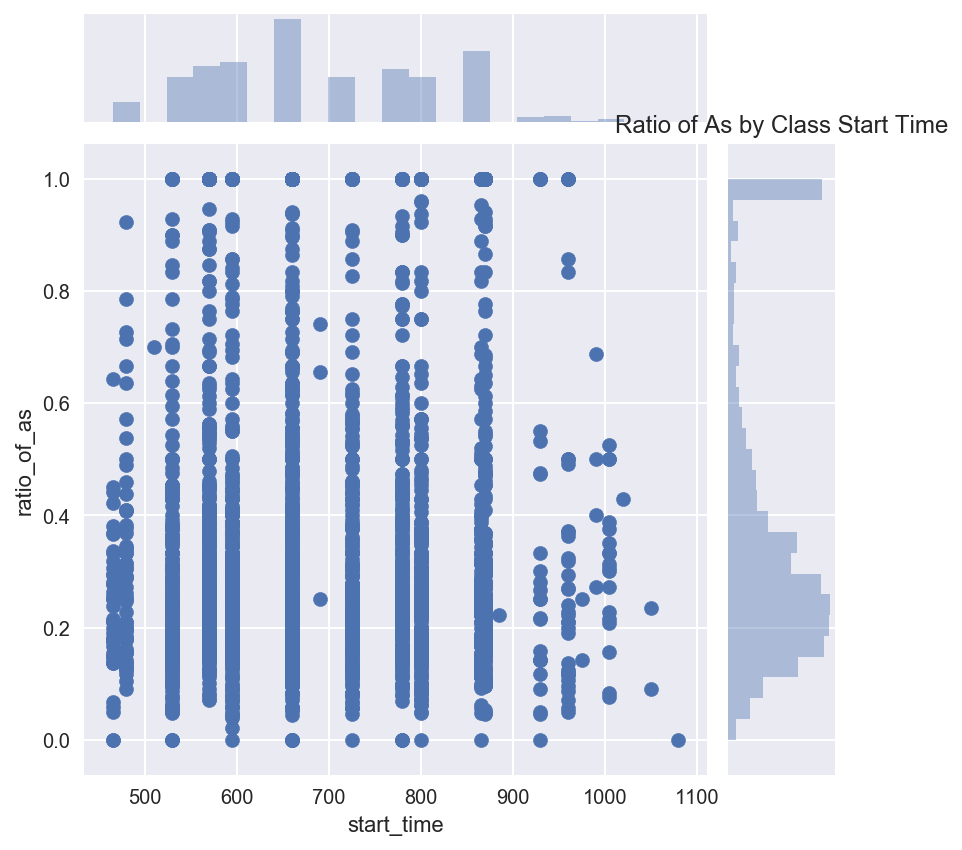

In [13]:
sns.jointplot('start_time', 'ratio_of_as',cleaned_df)
plt.title('Ratio of As by Class Start Time')
plt.show();

In [14]:
cleaned_df['section_type'].value_counts()

LEC    2629
SEM      32
Name: section_type, dtype: int64

Seperate classes into morning and afternoon.

In [15]:
morning_df = cleaned_df.loc[cleaned_df['start_time'] < 720]
afternoon_df = cleaned_df.loc[cleaned_df['start_time'] >= 720]

In [16]:
morning_df.shape

(1467, 14)

In [17]:
afternoon_df.shape

(1194, 14)

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


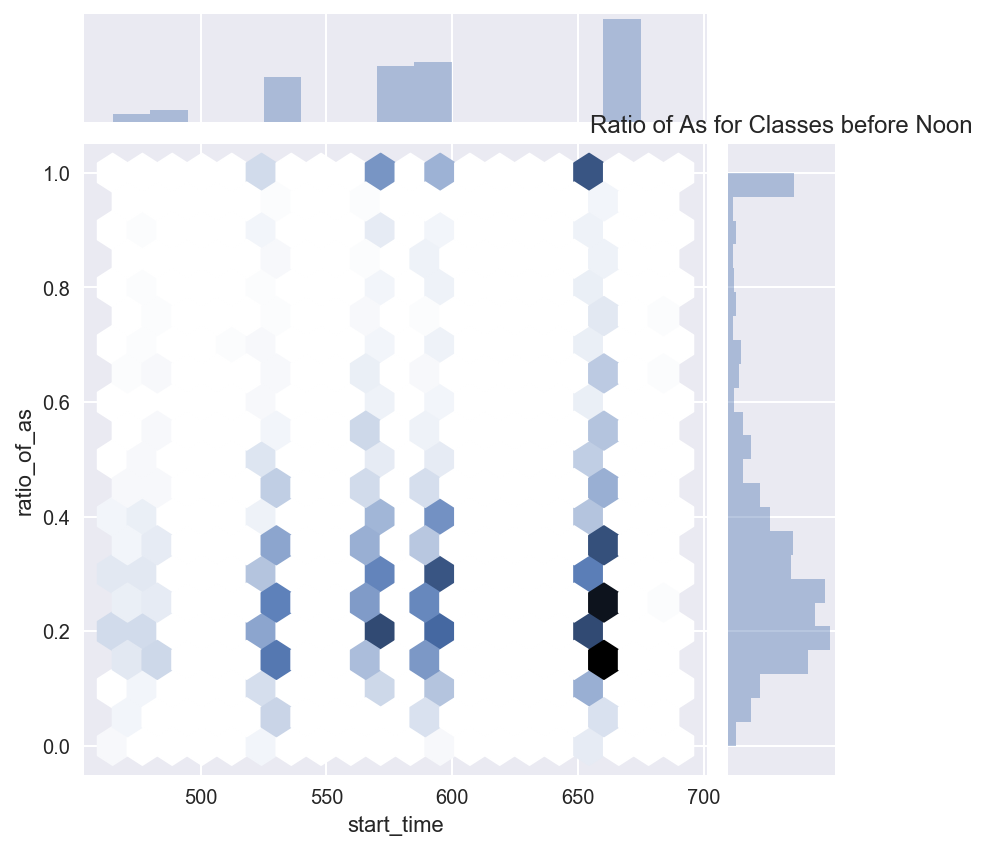

In [18]:
sns.jointplot('start_time', 'ratio_of_as',morning_df,kind='hex')
plt.title('Ratio of As for Classes before Noon')
plt.show();

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


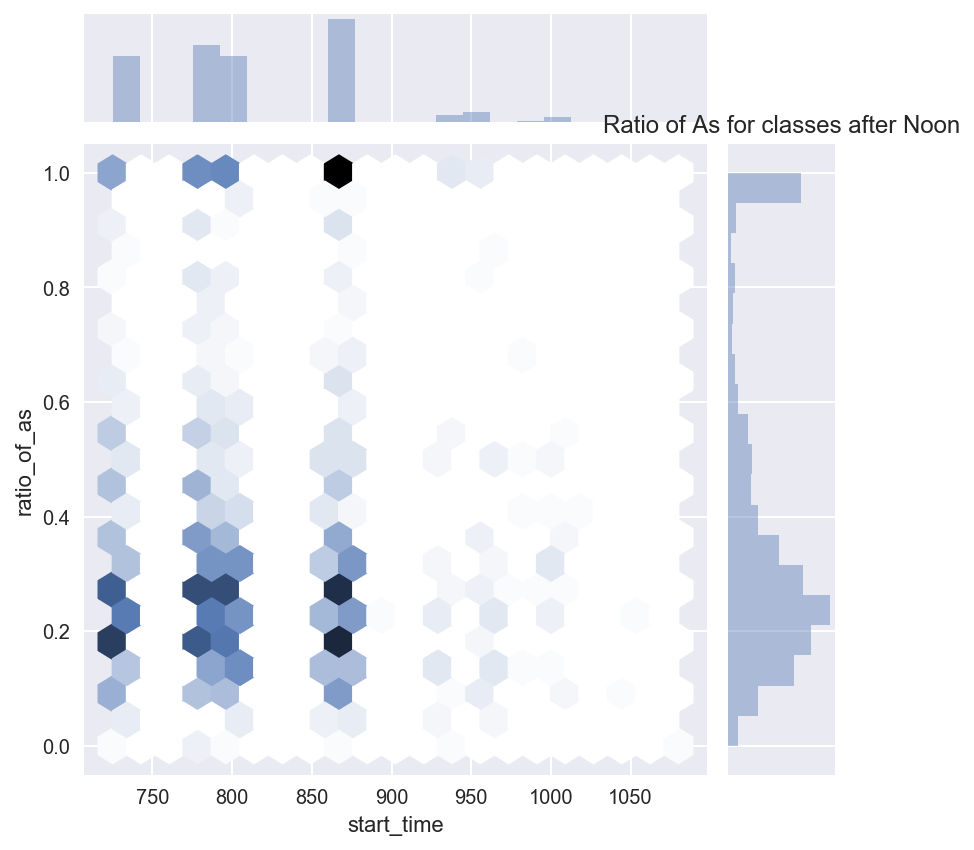

In [19]:
sns.jointplot('start_time', 'ratio_of_as',afternoon_df,kind='hex')
plt.title('Ratio of As for classes after Noon')
plt.show();

## Determine Sample Size

In [20]:
moe = 0.1
z = 1.96 # z value for alpha 0.05

vars_and_n = {'morn': (np.var(morning_df['ratio_of_as']), len(morning_df['ratio_of_as'])),
              'after': (np.var(afternoon_df['ratio_of_as']), len(afternoon_df['ratio_of_as']))}

n = get_sample_size(moe, z, vars_and_n)
n

56

We will use samples from morning and afternoon of size 56.

## Testing: T-Test

In [21]:
np.random.seed(20)

morning = morning_df['ratio_of_as']
afternoon = afternoon_df['ratio_of_as']

morning_sample = np.random.choice(morning, size=n)
afternoon_sample = np.random.choice(afternoon, size=n)

In [22]:
t, p = stats.ttest_ind(morning_sample, afternoon_sample)
print("pvalue: " + str(round(p, 3)))

pvalue: 0.248


Our p-value is about 0.248 which is greater than our *alpha* of 0.05. This means that we cannot reject the null hypothesis. Even when we look only at math classes we still cannot say that there is a statistical difference in the ratio of A's of a class depending on if the class is before or after noon. 